In [1]:
#using CUDA
using Test
using BenchmarkTools

using Plots
using LaTeXStrings
using Colors, ColorSchemes
cs1 = ColorScheme(range(colorant"red", colorant"royalblue1", length=5));
cs2 = ColorScheme(range(colorant"red", colorant"royalblue1", length=7));
cs3 = ColorScheme(range(colorant"red", colorant"darkblue", length=10));

#using QuadGK

#using Profile, ProfileSVG

using Base.Threads: @threads, @spawn
#ENV["JULIA_NUM_THREADS"]

## Parameters

In [2]:
const e_charge = 1.60217663E-19 
const r_e = 2.8179402895E-15
mec2 = 510998.94999999995

rho = 1.5
gamma = 10000.0
phi_m = 0.2

beta = (1-1/gamma^2)^(1/2)
lamb = 0.01/rho

# const phi_m = 0.5/rho

#sigma_z = 50e-6
#sigma_x = 50e-6

p0c = gamma * beta * mec2

#L0 = (24*sigma_z*rho^2)^(1/3)

5.109989474450051e9

## Beam initialization

In [3]:
using Distributions, Random

# Fake Gaussian beam

Np = 5000000
Q = 5E-9

charges = ones(Np)*Q/Np;

bb = Array{Float64, 2}(undef, 6, Np);
Random.seed!(1234)

#bb[1,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[2,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[3,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[4,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[5,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[6,1:Np-1] = rand(Normal(0, 1E-6), Np-1);

#bb[1, Np] = -0.0002666613359011983
#bb[2, Np] = 0.0
#bb[3, Np] = 0.0
#bb[4, Np] = 0.0
#bb[5, Np] = -0.00027260644226281925
#bb[6, Np] = 0.0


bb[1,1:Np] = rand(Normal(0, 50E-6), Np);
bb[2,1:Np] = rand(Normal(0, 50E-6), Np);
bb[3,1:Np] = rand(Normal(0, 50E-6), Np);
bb[4,1:Np] = rand(Normal(0, 50E-6), Np);
bb[5,1:Np] = rand(Normal(0, 50E-6), Np);
bb[6,1:Np] = rand(Normal(0, 1E-6), Np);

In [4]:
zmin = minimum(bb[5,:])
zmax = maximum(bb[5,:])
xmin = minimum(bb[1,:])
xmax = maximum(bb[1,:])

0.0002666613359011983

## Wakes

In [54]:
include("core/kick.jl")

csr2d_kick_calc_case_C (generic function with 1 method)

In [8]:
z_b = bb[5,:]
x_b = bb[1,:]
nz = 301
nx = 201
weight = charges
zmin = minimum(z_b)
    zmax = maximum(z_b)
    xmin = minimum(x_b)
    xmax = maximum(x_b)
    
    #zmin = -5*50E-6
    #zmax = 5*50E-6
    #xmin = -5*50E-6
    #xmax = 5*50E-6
    
    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)
    Δ = (dz, dx)
    
    zv = LinRange(zmin, zmax, nz);
    xv = LinRange(xmin, xmax, nx);

    # Charge deposition
    println(" Applying charge deposition...")
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)
    
    nn = sum(charge_grid) *dz*dx
    lambda_grid = charge_grid ./ nn;

 Applying charge deposition...


In [72]:
lamb_b(z::Float64, x::Float64) = interp_will(z, x, lambda_grid, zmin, zmax, xmin, xmax)  

lamb_b (generic function with 1 method)

In [81]:
lamb_b(0.0,0.0)
chi(xp::Float64) = ( 0.0 - xp )/rho
zod(xp::Float64)  = rho*(lamb - beta*sqrt(lamb^2 + chi(xp)^2))
z_near(xp::Float64) = -beta*abs(x_ob - xp) 

z_near (generic function with 1 method)

In [234]:
function compute_Ws_case_E_simple(z_ob::Float64, x_ob::Float64; 
        gamma::Float64, rho::Float64, lamb::Float64)
    
    beta = (1-1/gamma^2)^(1/2)
    
    #lamb_b(z::Float64, x::Float64) = interp_will(z, x, charge_grid, zmin, zmax, xmin, xmax)    
    
  ## integral    
    #iii1(z::Float64) =  psi_s_case_E((z_ob-z), (x_ob-xp), gamma)*lamb_2d_dz(z,xp)
 #   if dimension == 1
 #       iii = z -> Es_case_E((z_ob-z), (x_ob-xp), gamma)*lamb_b(z,xp)
 #   elseif dimension == 2
 #       iii = z -> Fx_case_E((z_ob-z), (x_ob-xp), gamma)*lamb_b(z,xp)
 #   end    
    
    chi(xp) = ( x_ob - xp )/rho
    zod(xp)  = rho*(lamb - beta*sqrt(lamb^2 + chi(xp)^2))
    z_near(xp) = -beta*abs(x_ob - xp) 
    
    println(z_near(1E-6))
    
    L_far = rho*lamb
    psi_s_case_E_far(x) = 1/(sqrt(x^2 + L_far^2) - beta*L_far)
    psi_s_case_E_near(x) = 1/abs(x)
    
    sigma_x = 50E-6
    sigma_z = 50E-6
    lamb_2d(z, x) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2) 
    
    
    iii2(xp) = psi_s_case_E_far( x_ob-xp )*lamb_2d(z_ob-zod(xp), xp)
    iii3(xp) = -psi_s_case_E_near( x_ob-xp )*lamb_2d(z_ob-z_near(xp), xp)
    
    iii4(xp) = -psi_s_case_E_near( x_ob-xp )
    println(iii4(1E-6))
    
    println(iii3(1E-6))
    
    println(lamb_2d(z_ob-z_near(1E-6), 1E-6)/abs(3*50E-6 - 1E-6))
    
    ifar_1 = QTS_will(iii2, -5*sigma_x, x_ob, 6)       
    ifar_2 = QTS_will(iii2, x_ob, 5*sigma_x, 6)     
    
    #ifar = quadgk(xp -> iii2(xp), -5*sigma_x, 5*sigma_x,  rtol=1e-4)[1]
    
    inear_1 = QTS_will(iii3, -5*sigma_x, x_ob-1E-16, 6)       
    inear_2 = QTS_will(iii3, x_ob+1E-16, 5*sigma_x, 6) 
    
    println("iii3:", iii3(x_ob))
    println("iii3:", iii3(5*sigma_x))
    
    #return (ifar_1 + ifar_2)*(-1.0/gamma^2)    
    #return (inear_1 + inear_2)*(-1.0/gamma^2)  
    #return (ifar_1 + ifar_2 + inear_1 + inear_2)*(-1.0/gamma^2)  
    
    return (ifar_2 + ifar_2)*(-1.0/gamma^2)  

end

compute_Ws_case_E_simple (generic function with 1 method)

In [233]:
compute_Ws_case_E_simple(-5*50E-6, -5*50E-6; gamma, rho, lamb)

-0.000250999998745
-3984.0637450199197
-2.5353194251031125e11
4.2709072194690015e11
iii3:-Inf
iii3:-1.7682683744604595


-0.0002905133701984342

In [9]:
compute_wake_case_B(0.0, 0.0; 
        gamma=5000.0, rho=rho, phi=0.2, nxp=301, 
        charge_grid=lambda_grid, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax, dimension=1)

-234952.16502164776

In [10]:
compute_Ws_case_E_boundary(0E-6, 0.0; 
        gamma=5000.0, rho=rho, lamb=lamb, nxp=201,
        charge_grid=lambda_grid, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax, dimension=1)

-77812.70291415504

In [11]:
nz

301

In [12]:
nx

201

In [55]:
dic_E = csr2d_kick_calc_case_E(bb[5,:], bb[1,:], charges,
    5000.0, rho, lamb,
    nz, nx, 501)

 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
  0.419674 seconds (50 CPU allocations: 3.094 KiB)
  0.000037 seconds (1 CPU allocation: 160 bytes)
 Interpolating wake value at the particle positions...


Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000251101, stop=0.000272606, length=301)
  "ddelta_ds"   => [-0.000573639, -0.000776256, -0.00113794, -0.00109906, -0.00…
  "Ws_grid"     => [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "xv"          => range(-0.000247439, stop=0.000266661, length=201)
  "dxp_ds"      => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0…

In [52]:
minimum(dic_E["Wx_grid"])

NaN

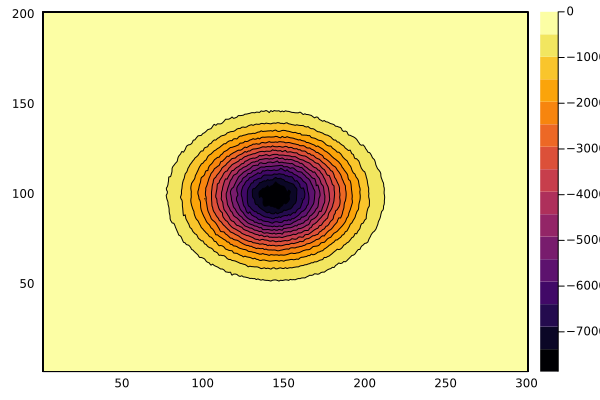

In [57]:
contourf(dic_E["Ws_grid"]')

In [25]:
csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges,
    gamma, rho, 0.01,
    nz, nx, 101)

 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  7.414340 seconds (59 CPU allocations: 3.422 KiB)
  7.023695 seconds (59 CPU allocations: 3.453 KiB)
 Interpolating wake value at the particle positions...


Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000251101, stop=0.000272606, length=301)
  "ddelta_ds"   => [-0.00816382, -0.00911838, -0.0174828, -0.0211043, -0.019782…
  "Ws_grid"     => [-2072.24 -2013.62 … 2289.11 2348.45; -2137.09 -2077.49 … 23…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [1554.07 1514.77 … 1697.42 1735.37; 1594.33 1554.74 … 1737.8…
  "xv"          => range(-0.000247439, stop=0.000266661, length=201)
  "dxp_ds"      => [9.19524e-5, 0.000210453, 0.000195324, 0.000200304, 0.000201…

In [ ]:
zo_vec = CuArray([0.0, 1E-6, 2E-6, 3E-6])
#int_vec = similar(zo_vec)
Ws_vec = similar(zo_vec)

function qts_gpu!(Ws_vec, zo_vec::CuDeviceArray)
    
    v1 = range(1, 3, length = 3)
    v2 = range(1, 3, length = 3)
    #f1(x,y) = x+y
    #L3 = @. f1(v1, v2')
    
    
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(zo_vec)
        
        Ws_vec[i]  = compute_Ws_case_E_simple(zo_vec[i], 0.0, 
            gamma=5000.0, rho = 1.5, lamb=0.066667)  
    
    end
    return nothing
end

@cuda th
s=4 qts_gpu!(Ws_vec, zo_vec)

In [125]:
include("core/integrator.jl")

compute_Ws_case_E_simple (generic function with 1 method)

In [ ]:
compute_Ws_case_E_simple(z_ob::Float64, x_ob::Float64; 
        gamma::Float64, rho::Float64, lamb::Float64)

In [159]:
compute_Ws_case_E_simple(5*50E-6, 3*50E-6; 
        gamma=5000.0, rho=rho, lamb=lamb)

Inf

In [126]:
zo_vec = CuArray([0.0, 1E-6, 2E-6, 3E-6])
#int_vec = similar(zo_vec)
Ws_vec = similar(zo_vec)

function qts_gpu!(Ws_vec, zo_vec::CuDeviceArray)
    
    v1 = range(1, 3, length = 3)
    v2 = range(1, 3, length = 3)
    #f1(x,y) = x+y
    #L3 = @. f1(v1, v2')
    
    
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(zo_vec)
        
        Ws_vec[i]  = compute_Ws_case_E_simple(zo_vec[i], 0.0, 
            gamma=5000.0, rho = 1.5, lamb=0.066667)  
    
    end
    return nothing
end

@cuda th
s=4 qts_gpu!(Ws_vec, zo_vec)

CUDA.HostKernel{typeof(qts_gpu!), Tuple{CuDeviceVector{Float64, 1}, CuDeviceVector{Float64, 1}}}(qts_gpu!, CuContext(0x00000000060724e0, instance d6fc0acb800f8a11), CuModule(Ptr{Nothing} @0x0000000013ba3590, CuContext(0x00000000060724e0, instance d6fc0acb800f8a11)), CuFunction(Ptr{Nothing} @0x000000001327eef0, CuModule(Ptr{Nothing} @0x0000000013ba3590, CuContext(0x00000000060724e0, instance d6fc0acb800f8a11))), CUDA.KernelState(Ptr{Nothing} @0x0000155361c00000))

In [11]:
include("core/kick.jl")

csr2d_kick_calc_case_C (generic function with 1 method)

In [ ]:
dic_B_02 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, 5000.0, rho, 0.2, 201, 101, 301)

In [7]:
dic_B = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges,
                            gamma, rho, 0.5,
                            201, 101, 101)

 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  3.499448 seconds (132.95 k CPU allocations: 7.226 MiB)
  3.541404 seconds (58 CPU allocations: 3.688 KiB)
 Interpolating wake value at the particle positions...


Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000251101, stop=0.000272606, length=201)
  "ddelta_ds"   => [0.000211921, -0.00151062, -0.0014308, -0.00207364, -0.00175…
  "Ws_grid"     => [-2074.44 -1957.28 … 2231.55 2349.89; -2172.26 -2052.53 … 23…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [1554.9 1476.06 … 1659.5 1735.6; 1615.54 1536.1 … 1720.29 17…
  "xv"          => range(-0.000247439, stop=0.000266661, length=101)
  "dxp_ds"      => [0.000160681, 0.000275486, 0.00030124, 0.000317338, 0.000317…

In [ ]:
compute_Ws_case_E_boundary(0.0, 0.0, 5000.0, 0.01/1.5)

In [18]:
0.01/1.5

0.006666666666666667

In [21]:
compute_Ws_case_E_simple(0.0, 0.0, gamma=5000.0, rho=1.5, lamb=0.0066666667)

-77509.43931820511

In [25]:
compute_Ws_case_E_boundary(0.0, 0.0, gamma=5000.0, rho=1.5, lamb=0.0066666667, nxp=101, 
        charge_grid=lambda_grid, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax, dimension=1)

-77509.43930559243

In [64]:
dic_E = csr2d_kick_calc_case_E_CPU(bb[5,:], bb[1,:], charges,
    5000.0, 1.5, 0.006666666667,
    301, 201, 101)

 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
 Interpolating wake value at the particle positions...


Dict{String, AbstractArray{Float64}} with 4 entries:
  "zv"          => range(-0.000251101, stop=0.000272606, length=301)
  "Ws_grid"     => [-0.000529888 -0.000540334 … -0.000474945 -0.000467654; -0.0…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "xv"          => range(-0.000247439, stop=0.000266661, length=201)

In [42]:
function Ws_case_E_multithread_lamb!(A, Δ, charge_grid, 
                            gamma, rho, lamb, nxp, zmin, zmax, xmin, xmax, dimension)
  
    dz, dx = Δ
    nz, nx =  size(A) 
    
    @sync for i in 1:nz
        @spawn for j in 1:nx
            #ij = @inbounds CartesianIndices(A)[i]
            #z = zmin + dz*(ij[1]-1)
            #x = zmin + dx*(ij[2]-1)      
            
            z = zmin + dz*(i-1)
            x = xmin + dx*(j-1)
            
            A[i,j] = compute_Ws_case_E_boundary(z, x, 
            gamma=gamma, rho=rho, lamb=lamb, nxp=nxp,
            charge_grid=charge_grid, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax, dimension=dimension)  
          
        end
    end

end

Ws_case_E_multithread_lamb! (generic function with 1 method)

In [36]:
Ws_grid_E = Array{Float64}(undef, 301, 201);

In [48]:
size(lambda_grid)

(301, 201)

In [55]:
Ws_case_E_multithread_lamb!(Ws_grid_E, (dz, dx), lambda_grid, 
                            5000.0, 1.5, 0.1/1.5, 101, zmin, zmax, xmin, xmax, 1)

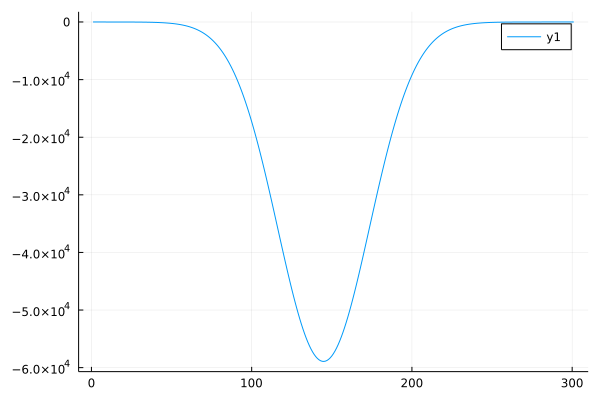

In [56]:
plot(Ws_grid_E[:,101])

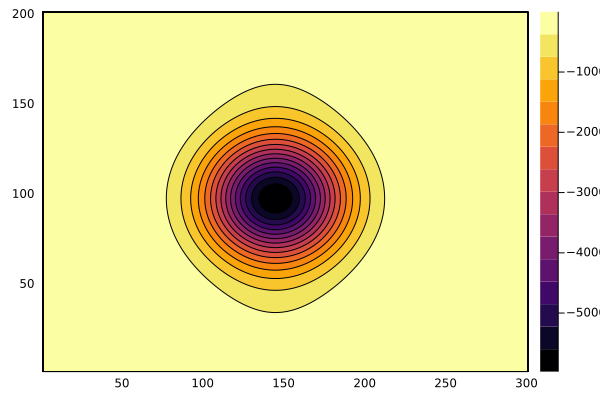

In [57]:
contourf(Ws_grid_E')

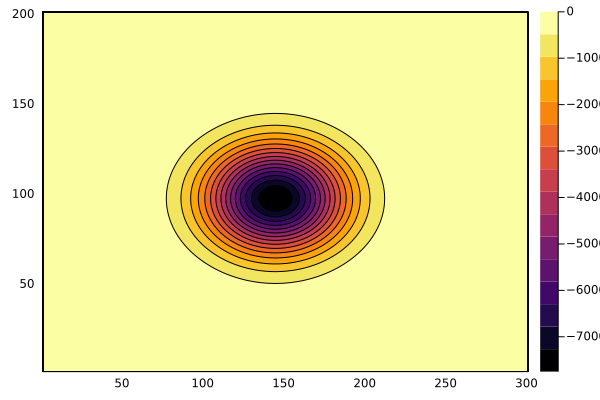

In [59]:
contourf(dic_E["Ws_grid"]')

In [96]:
Ws_grid_E = Array{Float64}(undef, 201, 101);

In [99]:
nz = 201
nx = 101
dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)
    Δ = (dz, dx)

(2.6185391076675645e-6, 5.141001400328897e-6)

In [103]:
Ws_case_E_multithread_lamb!(Ws_grid_E, Δ, lambda_grid, 
                            gamma, rho, lamb, 101, zmin, zmax, xmin, xmax, 1)

In [102]:
function Ws_case_E_multithread_lamb!(A, Δ, charge_grid, 
                            gamma, rho, lamb, nxp, zmin, zmax, xmin, xmax, dimension)
  
    dz, dx = Δ
    nz, nx =  size(A) 
    
    @sync for i in 1:nz
        @spawn for j in 1:nx
            ij = @inbounds CartesianIndices(A)[i]
            z = zmin + dz*(ij[1]-1)
            x = zmin + dx*(ij[2]-1)       
            
            A[i,j] = compute_Ws_case_E_boundary(z, x, 
            gamma=gamma, rho=rho, lamb=lamb, nxp=nxp,
            charge_grid=charge_grid, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax, dimension=dimension)  
          
        end
    end

end

Ws_case_E_multithread_lamb! (generic function with 1 method)

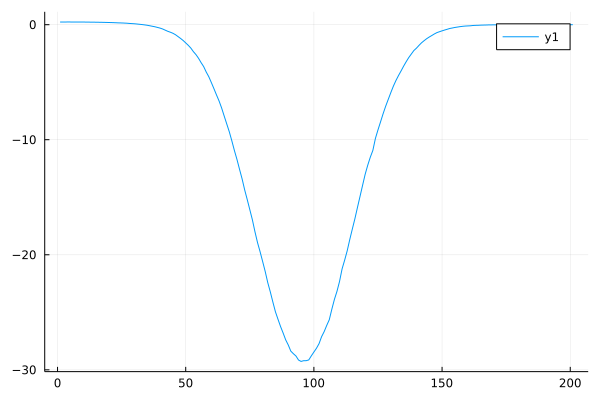

In [104]:
plot(Ws_grid_E[:, 51])

In [27]:
phi_m

0.2

In [235]:
include("core/kick.jl")

csr2d_kick_calc_case_C (generic function with 1 method)

In [26]:
dic_D = csr2d_kick_calc_case_D(bb[5,:], bb[1,:], charges,
                            gamma, rho, phi_m, lamb,
                            11, 3, 101)

 Applying charge deposition...
 Computing Case D wake grid(s) via GPU...
  7.589246 seconds (58 CPU allocations: 3.406 KiB)
  6.668142 seconds (59 CPU allocations: 3.469 KiB)
 Interpolating wake value at the particle positions...


Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000251101, stop=0.000272606, length=11)
  "ddelta_ds"   => [-0.000184698, -0.00120038, -0.00126888, -0.0014253, -0.0014…
  "Ws_grid"     => [-21.6489 -17.6833 -30.2143; -603.418 -393.279 -722.411; … ;…
  "lambda_grid" => [54.4498 453.596 44.3343; 3260.19 28742.1 2119.96; … ; 702.5…
  "Wx_grid"     => [0.215065 0.0166303 0.0367104; 7.80533 3.96364 4.36626; … ; …
  "xv"          => range(-0.000247439, stop=0.000266661, length=3)
  "dxp_ds"      => [3.11819e-5, 3.63891e-5, 3.68739e-5, 3.48672e-5, 3.73702e-5,…

In [63]:
dic_E = csr2d_kick_calc_case_E(bb[5,:], bb[1,:], charges,
                            gamma, rho, lamb,
                            11, 5, 101)

 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...


LoadError: MethodError: no method matching compute_wake_case_E_GPU!(::CuDeviceMatrix{Float64, 1}, ::Tuple{Float64, Float64}, ::CuDeviceMatrix{Float64, 1}, ::Float64, ::Float64, ::Float64, ::Int64, ::Float64, ::Float64, ::Float64, ::Float64, ::Int64)
[0mClosest candidates are:
[0m  compute_wake_case_E_GPU!(::CuDeviceArray, ::Any, ::CuDeviceArray, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m) at /global/cfs/cdirs/m669/wlou1991/Julia/core/kick.jl:106

In [ ]:
compute_Ws_case_E_simple(z, x, 
            gamma=gamma, rho=rho, lamb=lamb)  

In [25]:
include("core/kick.jl")

csr2d_kick_calc_case_C (generic function with 1 method)

In [17]:
zo_vec = LinRange(-5*50E-6, 5*50E-6, 301)

301-element LinRange{Float64, Int64}:
 -0.00025,-0.000248333,-0.000246667,…,0.000246667,0.000248333,0.00025

In [26]:
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_B["Ws_grid"], zmin, zmax, xmin, xmax)
    
Ws_vec = map(Ws_interp, collect(1:301));
scatter(zo_vec, Ws_vec)

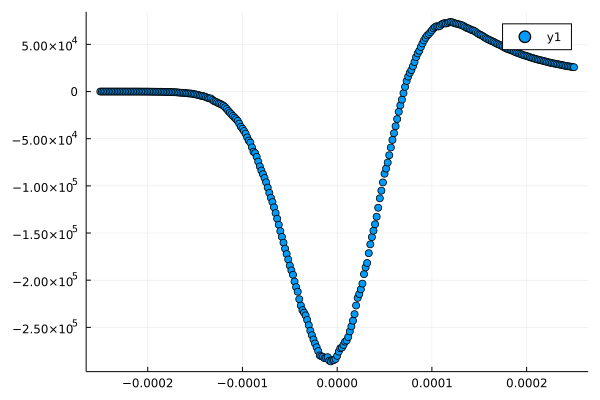

In [10]:
nzo = 201
#sigma_z = 50E-6
#zo_vec = LinRange(-5*sigma_z, 5*sigma_z, nzo)

zo_vec = LinRange(zmin, zmax, nzo)

201-element LinRange{Float64, Int64}:
 -0.000251101,-0.000248483,-0.000245864,…,0.000267369,0.000269988,0.000272606

## Case A

In [60]:
using DelimitedFiles

In [14]:
phi = 0.01
nz = 201
nx = 101
dic_dat = csr2d_kick_calc_case_A(bb[5,:], bb[1,:], charges, gamma, rho, phi, 301, 201, 301)


 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  1.905895 seconds (53 CPU allocations: 3.234 KiB)
  1.513343 seconds (54 CPU allocations: 3.297 KiB)
 Interpolating wake value at the particle positions...


Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000251101, stop=0.000272606, length=301)
  "ddelta_ds"   => [0.00865833, 0.0115254, 0.016581, 0.0181481, 0.0199314, 0.01…
  "Ws_grid"     => [4.30974e-6 4.564e-6 … -0.000185093 -0.000169737; 0.00062982…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [-3.64124e-7 -3.61779e-7 … 1.35464e-6 1.34335e-6; 8.42404e-7…
  "xv"          => range(-0.000247439, stop=0.000266661, length=201)
  "dxp_ds"      => [4.34186e-5, 5.9023e-5, 8.31298e-5, 9.19413e-5, 0.000100518,…

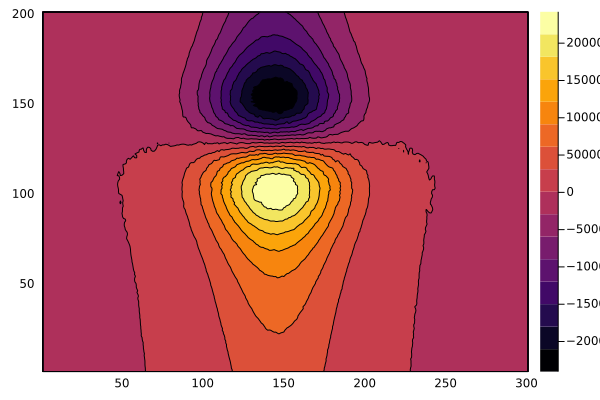

In [260]:
contourf(dic_dat["Ws_grid"]')

In [18]:
phi = 0.01
fname = "spec_gamma_10000_rho_1.5/Ws_case_A_phi_" * string(phi) * ".dat"
open(fname, "w") do io
           writedlm(io, dic_dat["Ws_grid"])
       end

In [ ]:
dic_D = csr2d_kick_calc_case_D(bb[5,:], bb[1,:], charges,
                            gamma, rho, phi_m, lamb,
                            11, 3, 101)

In [ ]:
dic_E = csr2d_kick_calc_case_E_CPU(bb[5,:], bb[1,:], charges, gamma, rho, lamb, 301, 201, 301)

In [66]:
for lamb in 0.005:0.005:0.2  
    
    dic_dat = csr2d_kick_calc_case_E_CPU(bb[5,:], bb[1,:], charges, gamma, rho, lamb, 301, 201, 301)
    
    fname = "spec_gamma_10000_rho_1.5/Ws_case_E_lamb_" * string(lamb) * ".dat"
    open(fname, "w") do io
           writedlm(io, dic_dat["Ws_grid"])
       end

end

 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case E wake grid(s) via GPU...
 Interpolating wake value at th

In [28]:
for lamb in 0.005:0.005:0.2  
    
    dic_dat = csr2d_kick_calc_case_D(bb[5,:], bb[1,:], charges, gamma, rho, 0.2, lamb, 301, 201, 301)
    
    fname = "spec_gamma_10000_rho_1.5/Ws_case_D_lamb_" * string(lamb) * ".dat"
    open(fname, "w") do io
           writedlm(io, dic_dat["Ws_grid"])
       end
    fname = "spec_gamma_10000_rho_1.5/Wx_case_D_lamb_" * string(lamb) * ".dat"
    open(fname, "w") do io
           writedlm(io, dic_dat["Wx_grid"])
       end
end

 Applying charge deposition...
 Computing Case D wake grid(s) via GPU...
 35.313724 seconds (95 CPU allocations: 5.078 KiB)
 34.242136 seconds (88 CPU allocations: 4.906 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case D wake grid(s) via GPU...
 35.183695 seconds (94 CPU allocations: 5.047 KiB)
 34.422444 seconds (88 CPU allocations: 4.906 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case D wake grid(s) via GPU...
 34.926470 seconds (94 CPU allocations: 5.047 KiB)
 33.443872 seconds (88 CPU allocations: 4.906 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case D wake grid(s) via GPU...
 35.836006 seconds (96 CPU allocations: 5.109 KiB)
 34.132006 seconds (94 CPU allocations: 5.078 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case D wake grid(s) via GPU...
 35.715

In [61]:
for phi in 0.001:0.001:0.009
    
    dic_dat = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, gamma, rho, phi, 301, 201, 301)
    
    fname = "spec_gamma_10000_rho_1.5/Ws_case_B_phi_" * string(phi) * ".dat"
    open(fname, "w") do io
           writedlm(io, dic_dat["Ws_grid"])
       end
    fname = "spec_gamma_10000_rho_1.5/Wx_case_B_phi_" * string(phi) * ".dat"
    open(fname, "w") do io
           writedlm(io, dic_dat["Wx_grid"])
       end
end

 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
 16.122663 seconds (68 CPU allocations: 3.719 KiB)
 15.958855 seconds (68 CPU allocations: 3.750 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
 16.291205 seconds (71 CPU allocations: 4.109 KiB)
 16.127935 seconds (70 CPU allocations: 4.078 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
 16.563396 seconds (70 CPU allocations: 4.078 KiB)
 16.317773 seconds (85 CPU allocations: 4.484 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
 16.922139 seconds (70 CPU allocations: 4.078 KiB)
 16.532521 seconds (70 CPU allocations: 4.078 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
 17.333

In [ ]:
for phi in 0.01:0.005:0.2  

In [62]:
for phi in 0.001:0.001:0.009
    
    dic_dat = csr2d_kick_calc_case_A(bb[5,:], bb[1,:], charges, gamma, rho, phi, 301, 201, 301)
    
    fname = "spec_gamma_10000_rho_1.5/Ws_case_A_phi_" * string(phi) * ".dat"
    open(fname, "w") do io
           writedlm(io, dic_dat["Ws_grid"])
       end
    fname = "spec_gamma_10000_rho_1.5/Wx_case_A_phi_" * string(phi) * ".dat"
    open(fname, "w") do io
           writedlm(io, dic_dat["Wx_grid"])
       end
end

 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  1.275418 seconds (53 CPU allocations: 3.250 KiB)
  1.227869 seconds (54 CPU allocations: 3.312 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  1.219725 seconds (53 CPU allocations: 3.250 KiB)
  1.226090 seconds (55 CPU allocations: 3.609 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  1.218095 seconds (55 CPU allocations: 3.344 KiB)
  1.225865 seconds (54 CPU allocations: 3.312 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  1.216810 seconds (55 CPU allocations: 3.344 KiB)
  1.225548 seconds (54 CPU allocations: 3.312 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  1.217

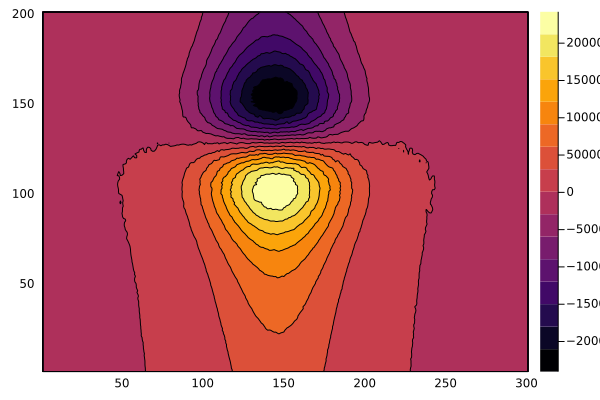

In [22]:
fname = "spec_gamma_1000_rho_1.5/Ws_case_A_phi_" * string(0.01) * ".dat"
gaga = readdlm(fname)
contourf(gaga')

In [18]:
dic_A_003 = csr2d_kick_calc_case_A(bb[5,:], bb[1,:], charges, gamma, rho, 0.03, 201, 101, 301)
dic_A_004 = csr2d_kick_calc_case_A(bb[5,:], bb[1,:], charges, gamma, rho, 0.04, 201, 101, 301)
dic_A_006 = csr2d_kick_calc_case_A(bb[5,:], bb[1,:], charges, gamma, rho, 0.06, 201, 101, 301)
dic_A_008 = csr2d_kick_calc_case_A(bb[5,:], bb[1,:], charges, gamma, rho, 0.08, 201, 101, 301)
dic_A_01 = csr2d_kick_calc_case_A(bb[5,:], bb[1,:], charges, gamma, rho, 0.1, 201, 101, 301)

 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.651766 seconds (52 CPU allocations: 3.203 KiB)
  1.086555 seconds (53 CPU allocations: 3.266 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.730760 seconds (53 CPU allocations: 3.266 KiB)
  0.879163 seconds (55 CPU allocations: 3.594 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.732553 seconds (52 CPU allocations: 3.203 KiB)
  0.734343 seconds (54 CPU allocations: 3.297 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.521268 seconds (54 CPU allocations: 3.562 KiB)
  1.258144 seconds (54 CPU allocations: 3.297 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.766

Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000251101, stop=0.000272606, length=201)
  "ddelta_ds"   => [1.42624e-6, 7.55429e-8, 4.83899e-8, 8.75139e-9, 4.11877e-8,…
  "Ws_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 2.03283e5 2.03464…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 10170.9 10180.0 ……
  "xv"          => range(-0.000247439, stop=0.000266661, length=101)
  "dxp_ds"      => [7.12405e-8, 3.73702e-9, 2.38805e-9, 4.16647e-10, 2.03223e-9…

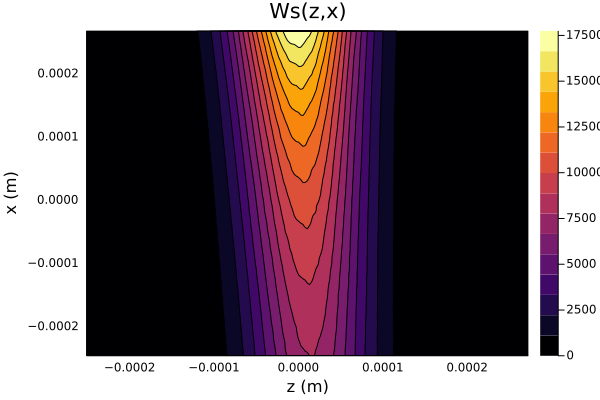

In [28]:
contourf(dic_A_003["zv"], dic_A_003["xv"], dic_A_003["Wx_grid"]', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

In [257]:
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_A["Ws_grid"], zmin, zmax, xmin, xmax)

#Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_A["Ws_grid"], -5*50E-6, 5*50E-6, -5*50E-6, 5*50E-6)
    
kaka = map(Ws_interp, collect(1:nzo));

In [153]:
dic_A["Ws_grid"][150,51]

702843.7796432079

In [231]:
compute_wake_case_A(0.0, 0.0, 
            gamma=gamma, rho=rho, phi=0.03, nxp=301, 
            charge_grid=lambda_grid, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax, dimension=1)

705402.7121701178

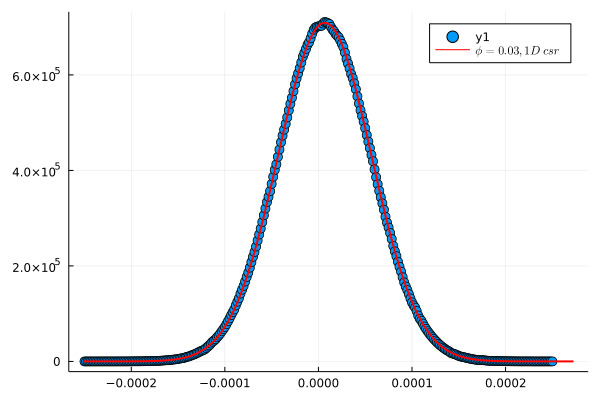

In [264]:
plot(zo_vec, kaka, markersize = 5, seriestype = :scatter)
#plot!(zo_vec, dic_A["Ws_grid"][:,51], label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter)
plot!(z_ob, WsA_int_vec_1, linewidth=2, label=L"\phi=0.03, 1D~ csr", color=cs1[1])

In [29]:
function Ws_on_axis_case_A(phi)
    dic = csr2d_kick_calc_case_A(bb[5,:], bb[1,:], charges, gamma, rho, phi, 201, 101, 301)
    
    Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic["Wx_grid"], zmin, zmax, xmin, xmax)
    #Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic["Ws_grid"], -5*50E-6, 5*50E-6, -5*50E-6, 5*50E-6)
    
    
    return map(Ws_interp, collect(1:201))
end

Ws_on_axis_case_A (generic function with 1 method)

In [30]:
Ws_A_003 = Ws_on_axis_case_A(0.03);
Ws_A_004 = Ws_on_axis_case_A(0.04);
Ws_A_006 = Ws_on_axis_case_A(0.06);
Ws_A_008 = Ws_on_axis_case_A(0.08);
Ws_A_01 = Ws_on_axis_case_A(0.1);

 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  1.188096 seconds (52 CPU allocations: 3.156 KiB)
  0.476270 seconds (54 CPU allocations: 3.297 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.680143 seconds (54 CPU allocations: 3.297 KiB)
  1.207338 seconds (53 CPU allocations: 3.266 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  1.237043 seconds (53 CPU allocations: 3.266 KiB)
  0.931071 seconds (54 CPU allocations: 3.281 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.992603 seconds (55 CPU allocations: 3.594 KiB)
  0.480505 seconds (54 CPU allocations: 3.297 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.900

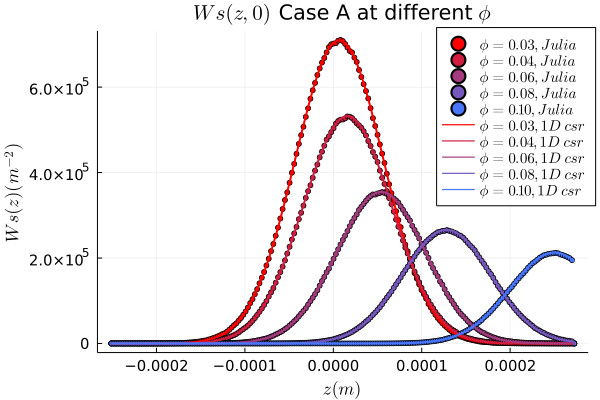

In [15]:
plot(zo_vec, Ws_A_003 , label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(zo_vec, Ws_A_004 , label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(zo_vec, Ws_A_006 , label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(zo_vec, Ws_A_008 , label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(zo_vec, Ws_A_01 , label=L"\phi=0.10, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

#plot(zo_vec, dic_A["Ws_grid"][:,51], label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter)

plot!(z_ob, WsA_int_vec_1, linewidth=2, label=L"\phi=0.03, 1D~ csr", color=cs1[1])
plot!(z_ob, WsA_int_vec_2, linewidth=2, label=L"\phi=0.04, 1D~ csr", color=cs1[2])
plot!(z_ob, WsA_int_vec_3, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[3])
plot!(z_ob, WsA_int_vec_4, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[4])
plot!(z_ob, WsA_int_vec_5, linewidth=2, label=L"\phi=0.10, 1D~ csr", color=cs1[5])

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ Case A at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=1Plots.mm, legend=(0.78, 0.96), legendfontsize = 10)

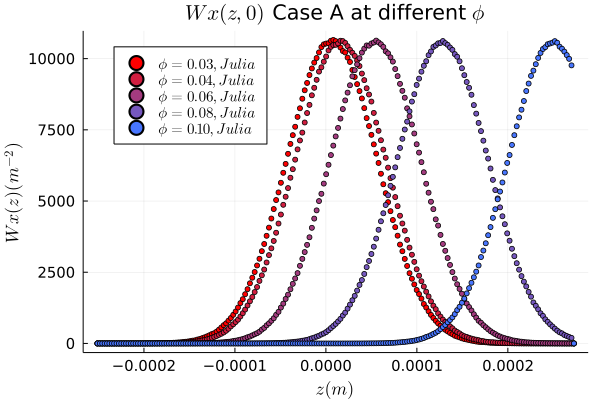

In [74]:
plot(zo_vec, Ws_A_003 , label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(zo_vec, Ws_A_004 , label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(zo_vec, Ws_A_006 , label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(zo_vec, Ws_A_008 , label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(zo_vec, Ws_A_01 , label=L"\phi=0.10, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

#plot(zo_vec, dic_A["Ws_grid"][:,51], label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter)

plot!#(z_ob, WsA_int_vec_1, linewidth=2, label=L"\phi=0.03, 1D~ csr", color=cs1[1])
plot!#(z_ob, WsA_int_vec_2, linewidth=2, label=L"\phi=0.04, 1D~ csr", color=cs1[2])
plot!#(z_ob, WsA_int_vec_3, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[3])
plot!#(z_ob, WsA_int_vec_4, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[4])
plot!#(z_ob, WsA_int_vec_5, linewidth=2, label=L"\phi=0.10, 1D~ csr", color=cs1[5])

plot!(xlabel=L"$z (m)", ylabel=L"$Wx(z) (m^{-2})$", title=L"$Wx(z,0)$ Case A at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=1Plots.mm, legend=(0.15, 0.90), legendfontsize = 10)

## Case C

In [59]:
dic_C_001 = csr2d_kick_calc_case_C(bb[5,:], bb[1,:], charges, gamma, rho, 0.1/rho, 0.01, 201, 101, 301)
dic_C_002 = csr2d_kick_calc_case_C(bb[5,:], bb[1,:], charges, gamma, rho, 0.1/rho, 0.02, 201, 101, 301)
dic_C_003 = csr2d_kick_calc_case_C(bb[5,:], bb[1,:], charges, gamma, rho, 0.1/rho, 0.03, 201, 101, 301)
dic_C_004 = csr2d_kick_calc_case_C(bb[5,:], bb[1,:], charges, gamma, rho, 0.1/rho, 0.04, 201, 101, 301)
dic_C_005 = csr2d_kick_calc_case_C(bb[5,:], bb[1,:], charges, gamma, rho, 0.1/rho, 0.05, 201, 101, 301)

 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  1.295737 seconds (52 CPU allocations: 3.219 KiB)
  0.656598 seconds (54 CPU allocations: 3.312 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  1.472096 seconds (55 CPU allocations: 3.609 KiB)
  0.887795 seconds (54 CPU allocations: 3.312 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  0.537493 seconds (53 CPU allocations: 3.281 KiB)
  0.854448 seconds (53 CPU allocations: 3.281 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  0.886656 seconds (53 CPU allocations: 3.281 KiB)
  1.706981 seconds (53 CPU allocations: 3.281 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  1.213

Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000251101, stop=0.000272606, length=201)
  "ddelta_ds"   => [1.69066e-6, 9.3884e-8, 4.37159e-8, 2.27745e-8, 3.43714e-8, …
  "Ws_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 118495.0 1.18727e…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 3950.68 3958.42 ……
  "xv"          => range(-0.000247439, stop=0.000266661, length=101)
  "dxp_ds"      => [5.62526e-8, 3.08775e-9, 1.42114e-9, 7.35844e-10, 1.11541e-9…

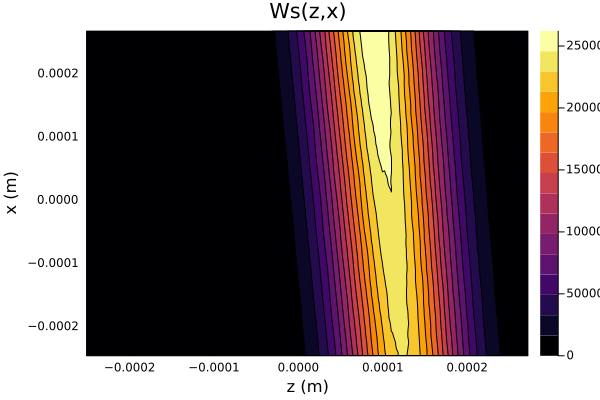

In [82]:
contourf(dic_C_003["zv"], dic_C_003["xv"], dic_C_001["Ws_grid"]', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

In [99]:
Ws_or_Wx = "Ws_grid"
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_C_001[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_C_001 = map(Ws_interp, collect(1:201));
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_C_002[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_C_002 = map(Ws_interp, collect(1:201));
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_C_003[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_C_003 = map(Ws_interp, collect(1:201));
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_C_004[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_C_004 = map(Ws_interp, collect(1:201));
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_C_005[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_C_005 = map(Ws_interp, collect(1:201));

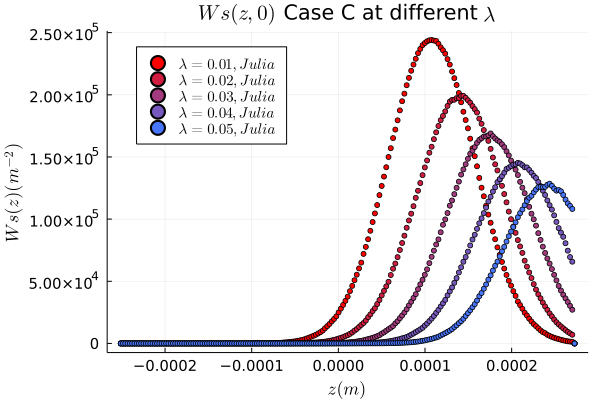

In [100]:
plot(zo_vec, Ws_C_001 , label=L"\lambda=0.01, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(zo_vec, Ws_C_002 , label=L"\lambda=0.02, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(zo_vec, Ws_C_003 , label=L"\lambda=0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(zo_vec, Ws_C_004 , label=L"\lambda=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(zo_vec, Ws_C_005 , label=L"\lambda=0.05, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

#plot(zo_vec, dic_A["Ws_grid"][:,51], label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter)

#plot!(z_ob, WsC_int_vec_1, linewidth=2, label=L"\lambda=0.01, 1D~ csr", color=cs1[1])
#plot!(z_ob, WsC_int_vec_2, linewidth=2, label=L"\lambda=0.02, 1D~ csr", color=cs1[2])
#plot!(z_ob, WsC_int_vec_3, linewidth=2, label=L"\lambda=0.03, 1D~ csr", color=cs1[3])
#plot!(z_ob, WsC_int_vec_4, linewidth=2, label=L"\lambda=0.04, 1D~ csr", color=cs1[4])
#plot!(z_ob, WsC_int_vec_5, linewidth=2, label=L"\lambda=0.05, 1D~ csr", color=cs1[5])

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ Case C at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=1Plots.mm, legend=(0.15, 0.90), legendfontsize = 10)

## Case B

In [120]:
dic_B_004 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, 5000.0, rho, 0.04, 201, 101, 301);
dic_B_006 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, 5000.0, rho, 0.06, 201, 101, 301);
dic_B_008 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, 5000.0, rho, 0.08, 201, 101, 301);
dic_B_012 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, 5000.0, rho, 0.12, 201, 101, 301);
dic_B_02 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, 5000.0, rho, 0.2, 201, 101, 301);

 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  5.889103 seconds (58 CPU allocations: 3.391 KiB)
  5.750146 seconds (58 CPU allocations: 3.422 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  5.845256 seconds (58 CPU allocations: 3.422 KiB)
  5.823046 seconds (59 CPU allocations: 3.719 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  5.843304 seconds (59 CPU allocations: 3.719 KiB)
  5.469081 seconds (58 CPU allocations: 3.422 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  5.887586 seconds (59 CPU allocations: 3.453 KiB)
  5.723831 seconds (59 CPU allocations: 3.453 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  5.390

In [134]:
include("core/kick.jl")

csr2d_kick_calc_case_C (generic function with 1 method)

In [135]:
#dic_B_012 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, gamma, rho, 0.12, 201, 101, 301);
dic_B_02 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, gamma, rho, 0.2, 201, 101, 301);

 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
 11.192192 seconds (62 CPU allocations: 3.516 KiB)
 10.008271 seconds (63 CPU allocations: 3.844 KiB)
 Interpolating wake value at the particle positions...


In [101]:
dic_B_004 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, gamma, rho, 0.04, 201, 101, 301);
dic_B_006 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, gamma, rho, 0.06, 201, 101, 301);
dic_B_008 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, gamma, rho, 0.08, 201, 101, 301);
dic_B_012 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, gamma, rho, 0.12, 201, 101, 301);
dic_B_02 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, gamma, rho, 0.2, 201, 101, 301);

 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  5.960930 seconds (57 CPU allocations: 3.359 KiB)
  5.903072 seconds (59 CPU allocations: 3.453 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  5.933392 seconds (58 CPU allocations: 3.422 KiB)
  5.835914 seconds (58 CPU allocations: 3.422 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  6.131677 seconds (57 CPU allocations: 3.359 KiB)
  5.809446 seconds (59 CPU allocations: 3.453 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  6.297398 seconds (58 CPU allocations: 3.422 KiB)
  5.689327 seconds (66 CPU allocations: 3.922 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  5.979

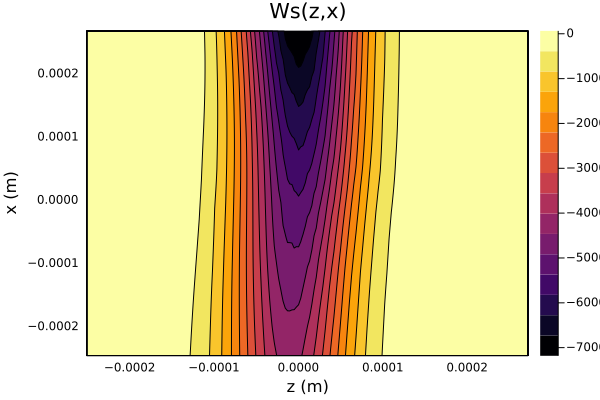

In [102]:
contourf(dic_B_004["zv"], dic_B_004["xv"], dic_B_004["Ws_grid"]', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

In [117]:
dic_B_02 = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges, 10000.0, rho, 0.2, 201, 101, 301);

 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  5.766181 seconds (57 CPU allocations: 3.359 KiB)
  5.690983 seconds (59 CPU allocations: 3.719 KiB)
 Interpolating wake value at the particle positions...


In [138]:
Ws_or_Wx = "Wx_grid"
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_B_004[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_B_004 = map(Ws_interp, collect(1:201));
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_B_006[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_B_006 = map(Ws_interp, collect(1:201));
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_B_008[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_B_008 = map(Ws_interp, collect(1:201));
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_B_012[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_B_012 = map(Ws_interp, collect(1:201));
Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic_B_02[Ws_or_Wx], zmin, zmax, xmin, xmax)
Ws_B_02 = map(Ws_interp, collect(1:201));

In [139]:
Ws_B_02;

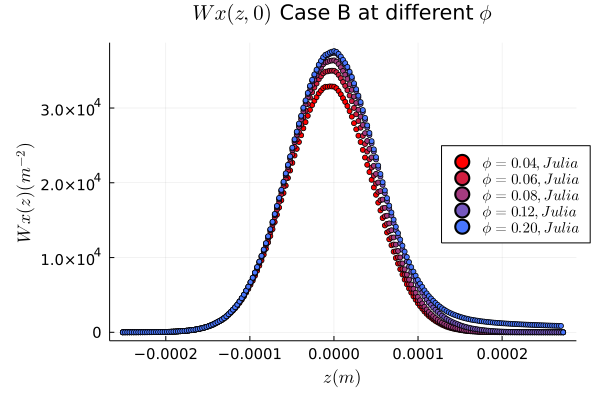

In [141]:
plot(zo_vec, Ws_B_004, label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(zo_vec, Ws_B_006, label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(zo_vec, Ws_B_008, label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(zo_vec, Ws_B_012, label=L"\phi=0.12, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(zo_vec, Ws_B_02, label=L"\phi=0.20, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])


#plot!(z_ob, WsB_int_vec_1, linewidth=2, label=L"\phi=0.04, 1D~ csr", color=cs1[1])
#plot!(z_ob, WsB_int_vec_2, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[2])
#plot!(z_ob, WsB_int_vec_3, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[3])
#plot!(z_ob, WsB_int_vec_4, linewidth=2, label=L"\phi=0.12, 1D~ csr", color=cs1[4])
#plot!(z_ob, WsB_int_vec_5, linewidth=2, label=L"\phi=0.20, 1D~ csr", color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Wx(z) (m^{-2})$", title=L"$Wx(z,0)$ Case B at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=(0.8, 0.6), legendfontsize = 10)
#plot(z_ob, Ws_caseB_mat_phi_2[102:202], label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])

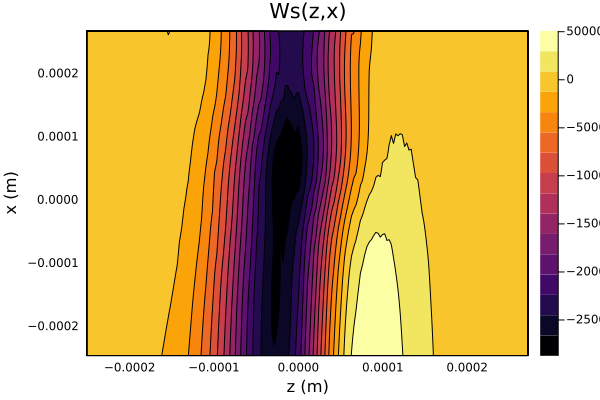

In [39]:
contourf(dic_B_003["zv"], dic_B_003["xv"], dic_B_01["Ws_grid"]', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

In [ ]:
plot(zo_vec, Ws_A_003 , label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(zo_vec, Ws_A_004 , label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(zo_vec, Ws_A_006 , label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(zo_vec, Ws_A_008 , label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(zo_vec, Ws_A_01 , label=L"\phi=0.10, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

#plot(zo_vec, dic_A["Ws_grid"][:,51], label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter)

#plot!(z_ob, WsA_int_vec_1, linewidth=2, label=L"\phi=0.03, 1D~ csr", color=cs1[1])
#plot!(z_ob, WsA_int_vec_2, linewidth=2, label=L"\phi=0.04, 1D~ csr", color=cs1[2])
#plot!(z_ob, WsA_int_vec_3, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[3])
#plot!(z_ob, WsA_int_vec_4, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[4])
#plot!(z_ob, WsA_int_vec_5, linewidth=2, label=L"\phi=0.10, 1D~ csr", color=cs1[5])

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Wx(z,0)$ Case A at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=1Plots.mm, legend=(0.15, 0.90), legendfontsize = 10)

In [ ]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)

plot(z_ob, Wx_caseA_mat_phi_003[102:202], label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Wx_caseA_mat_phi_004[102:202], label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Wx_caseA_mat_phi_006[102:202], label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Wx_caseA_mat_phi_008[102:202], label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Wx_caseA_mat_phi_01[102:202], label=L"\phi=0.10, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

plot!(z_ob, WxA_int_vec_1, linewidth=2, label=L"\phi=0.03, 1D~ csr", color=cs1[1])
plot!(z_ob, WxA_int_vec_2, linewidth=2, label=L"\phi=0.04, 1D~ csr", color=cs1[2])
plot!(z_ob, WxA_int_vec_3, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[3])
plot!(z_ob, WxA_int_vec_4, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[4])
plot!(z_ob, WxA_int_vec_5, linewidth=2, label=L"\phi=0.10, 1D~ csr", color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Wx(z,0)$ Case A at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=1Plots.mm, legend=(0.12, 0.90), legendfontsize = 10)

In [91]:
function Ws_on_axis_case_C(lamb)
    dic = csr2d_kick_calc_case_C(bb[5,:], bb[1,:], charges, gamma, rho, 0.1/rho, lamb, 201, 201, 301)
    
    Ws_interp(id) = interp_will(zo_vec[id], 0.0, dic["Ws_grid"], zmin, zmax, xmin, xmax)
    
    return map(Ws_interp, collect(1:nzo))
end

Ws_on_axis_case_C (generic function with 1 method)

In [92]:
Ws_C_001 = Ws_on_axis_case_C(0.01);
Ws_C_002 = Ws_on_axis_case_C(0.02);
Ws_C_003 = Ws_on_axis_case_C(0.03);
Ws_C_004 = Ws_on_axis_case_C(0.04);
Ws_C_005 = Ws_on_axis_case_C(0.05);

 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  0.948000 seconds (53 CPU allocations: 3.266 KiB)
  0.870749 seconds (53 CPU allocations: 3.297 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  0.888495 seconds (53 CPU allocations: 3.297 KiB)
  0.869655 seconds (53 CPU allocations: 3.297 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  0.889292 seconds (53 CPU allocations: 3.297 KiB)
  0.869473 seconds (53 CPU allocations: 3.297 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  0.890563 seconds (53 CPU allocations: 3.297 KiB)
  0.869574 seconds (53 CPU allocations: 3.297 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  0.884

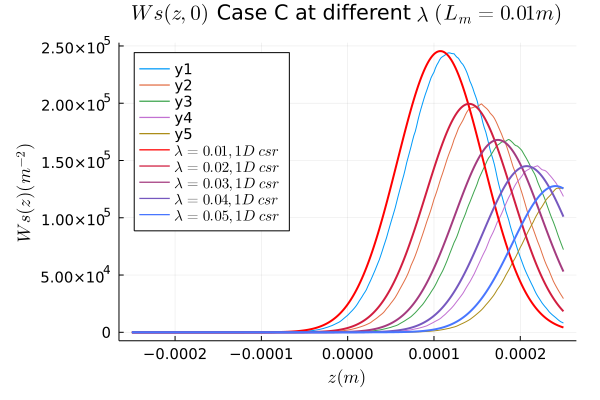

In [93]:
plot(zo_vec, Ws_C_001 )
plot!(zo_vec, Ws_C_002 )
plot!(zo_vec, Ws_C_003 )
plot!(zo_vec, Ws_C_004 )
plot!(zo_vec, Ws_C_005 )


plot!(z_ob, WsC_int_vec_1, linewidth=2, label=L"\lambda=0.01, 1D~ csr", color=cs1[1])
plot!(z_ob, WsC_int_vec_2, linewidth=2, label=L"\lambda=0.02, 1D~ csr", color=cs1[2])
plot!(z_ob, WsC_int_vec_3, linewidth=2, label=L"\lambda=0.03, 1D~ csr", color=cs1[3])
plot!(z_ob, WsC_int_vec_4, linewidth=2, label=L"\lambda=0.04, 1D~ csr", color=cs1[4])
plot!(z_ob, WsC_int_vec_5, linewidth=2, label=L"\lambda=0.05, 1D~ csr", color=cs1[5])

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ Case C at different $\lambda$ $(L_m=0.01m)$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:topleft, legendfontsize = 10)

# 1D theory

In [13]:
sigma_z = 50E-6


lamb_1d(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2)
lamb_1d_prime(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2) * (-z / sigma_z^2)

phi_m = 0.1/rho

# Case A Ws
function Ws_case_A_1D_theory(z_ob::Float64, phi::Float64)
    #alternative form
    return 4/phi/rho * lamb_1d( z_ob - rho*phi^3/6 )
end

# Case C Ws
function Ws_case_C_1D_theory(z_ob::Float64, phi_m::Float64, lamb::Float64)
    #alternative form
    return 4/rho/(phi_m + 2*lamb) * lamb_1d( z_ob - rho*phi_m^2*(phi_m+3*lamb)/6 )
end

Ws_case_C_1D_theory (generic function with 1 method)

In [108]:
std(bb[5,:])

5.001288671182304e-5

In [109]:
zmin

-0.00025110137927069357

In [14]:
phi = 0.02
WsA_1D(z_ob::Float64) = Ws_case_A_1D_theory(z_ob, phi)
WsA_1D(0.0)

WsC_1D(z_ob::Float64) = Ws_case_C_1D_theory(z_ob, phi_m, lamb)
WsC_1D(0.0)

sigma_z = 50E-6
#z_ob = range(-5*sigma_z, 5*sigma_z, length = 301)

z_ob = range(zmin, zmax, length = 301)

phi_vec = [0.03, 0.04, 0.06, 0.08, 0.1];
phi = phi_vec[1]
WsA_int_vec_1 = map(WsA_1D, z_ob);
phi = phi_vec[2]
WsA_int_vec_2 = map(WsA_1D, z_ob);
phi = phi_vec[3]
WsA_int_vec_3 = map(WsA_1D, z_ob);
phi = phi_vec[4]
WsA_int_vec_4 = map(WsA_1D, z_ob);
phi = phi_vec[5]
WsA_int_vec_5 = map(WsA_1D, z_ob);

lamb_vec = [0.01, 0.02, 0.03, 0.04, 0.05];
lamb = lamb_vec[1]
WsC_int_vec_1 = map(WsC_1D, z_ob);
lamb = lamb_vec[2]
WsC_int_vec_2 = map(WsC_1D, z_ob);
lamb = lamb_vec[3]
WsC_int_vec_3 = map(WsC_1D, z_ob);
lamb = lamb_vec[4]
WsC_int_vec_4 = map(WsC_1D, z_ob);
lamb = lamb_vec[5]
WsC_int_vec_5 = map(WsC_1D, z_ob);

In [168]:
WsA_int_vec_1_sig = WsA_int_vec_1;

In [171]:
WsA_int_vec_1_min = WsA_int_vec_1;

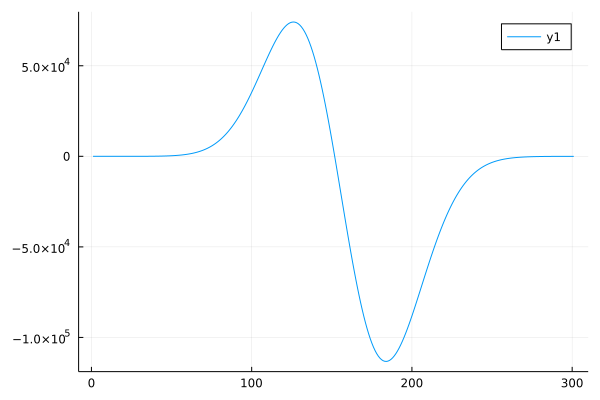

In [173]:
plot(WsA_int_vec_1_min - WsA_int_vec_1_sig)

### theory B/D

In [41]:
using QuadGK

lamb_1d(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2)
lamb_1d_prime(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2) * (-z / sigma_z^2)

z_L(phi::Float64) = rho*phi^3/24
coeff = -2/(3*rho^2)^(1/3)


# Case B boundary term ( for large phi this vanishes )
function Ws_case_B_1D_theory_boundary_term(z_ob::Float64, phi::Float64)
    #alternative form
    #return -4/phi/rho * lamb_1d( z_ob - rho*phi^3/24 )
    zL =  z_L(phi)
    return coeff* lamb_1d( z_ob - zL ) / zL^(1/3)
end



# Case B integral term ( for large phi this becomes the s-s wake )
function Ws_case_B_1D_theory_integral_term(z_ob::Float64, phi::Float64)
    w_ss(zp) = lamb_1d_prime(zp)/(z_ob - zp)^(1/3)
    return coeff*quadgk(w_ss, z_ob - z_L(phi), z_ob)[1]
end

# Case B Wx
function Wx_case_B_1D_theory(z_ob::Float64, phi::Float64)
    #alternative form
    return -4/rho * lamb_1d( z_ob )
end


# Case D boundary term ( for large phi_m this vanishes )
function Ws_case_D_1D_theory_boundary_term(z_ob::Float64, lamb::Float64, phi_m::Float64)
    x =  lamb*rho
    Lm = phi_m*rho   
    delta_s(l) =  l^3/24/rho^2*(l + 4*x)/(l + x)
    
    return - 4 * lamb_1d(z_ob - delta_s(Lm))/(Lm + 2*x)
end

# Case D integral term
# Check Dave Sagan's paper for the change-of-variable version of the integral 
function Ws_case_D_1D_theory_integral_term(z_ob::Float64, lamb::Float64, phi_m::Float64)
    x =  lamb*rho
    Lm = phi_m*rho     
    delta_s(l) =  l^3/24/rho^2*(l + 4*x)/(l + x)
    delta_s_prime(l) = l^2/8/rho^2*(l + 2*x)^2/(l + x)^2  
    ii(l) =  - 4/(l+2*x)* lamb_1d_prime(z_ob-delta_s(l))*delta_s_prime(l)
    
    return quadgk( ii, 0, Lm )[1]
end

Ws_case_D_1D_theory_integral_term (generic function with 1 method)

In [42]:
phi_ob = 0.01
WsB_1D(z_ob::Float64) = Ws_case_B_1D_theory_boundary_term(z_ob, phi_ob) + Ws_case_B_1D_theory_integral_term(z_ob, phi_ob)
WsB_1D(0.0);

lamb_temp = 0.01
WsD_1D(z_ob::Float64) = Ws_case_D_1D_theory_boundary_term(z_ob, lamb_temp, phi_m) + Ws_case_D_1D_theory_integral_term(z_ob, lamb_temp, phi_m)
WsD_1D(0.0)

z_ob = range(zmin, zmax, length = 301)

-0.00025110137927069357:1.7456927384450427e-6:0.00027260644226281925

In [43]:
phi_vec = [0.04, 0.06, 0.08, 0.12, 0.2];
phi_ob  = phi_vec[1]
WsB_int_vec_1 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[2]
WsB_int_vec_2 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[3]
WsB_int_vec_3 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[4]
WsB_int_vec_4 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[5]
WsB_int_vec_5 = map(WsB_1D, z_ob);

In [44]:
lamb_vec = [0.01, 0.02, 0.03, 0.05, 0.08];
lamb_temp = lamb_vec[1]
WsD_1D_vec_1 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[2]
WsD_1D_vec_2 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[3]
WsD_1D_vec_3 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[4]
WsD_1D_vec_4 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[5]
WsD_1D_vec_5 = map(WsD_1D, z_ob);